In [1]:
import numpy as np
import matplotlib.pylab as plot
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
import healpy as hp
from pylab import cm
from BurstCube.ReqSim.ReqSim import *
from BurstCube.ReqSim.ReqSimTools import *
from scipy import stats
import matplotlib.cm as cm

/Users/jracusin/anaconda/envs/py3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/jracusin/anaconda/envs/py3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


1.0099999982083028


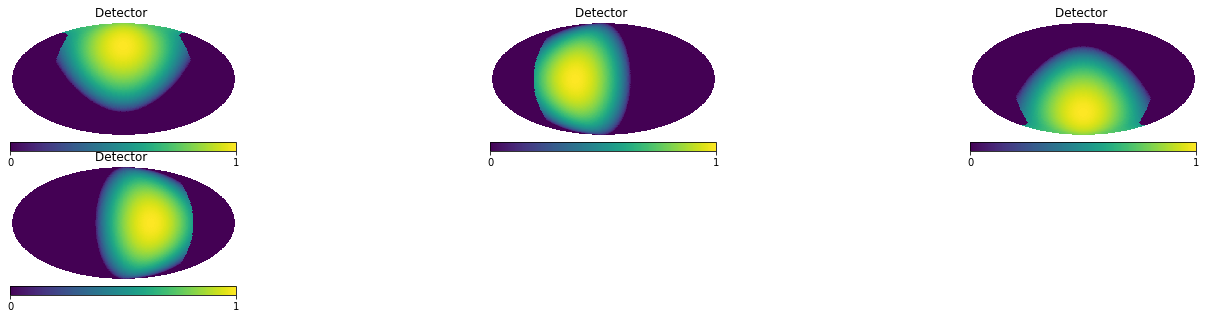

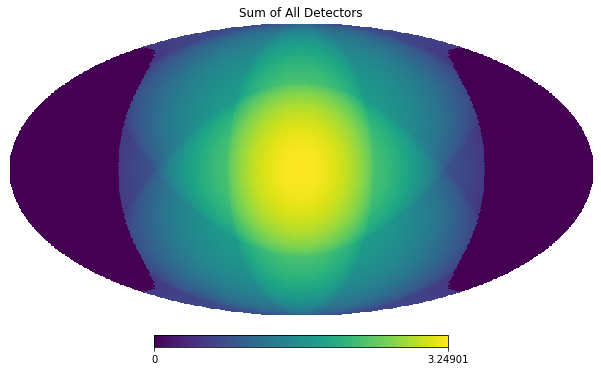

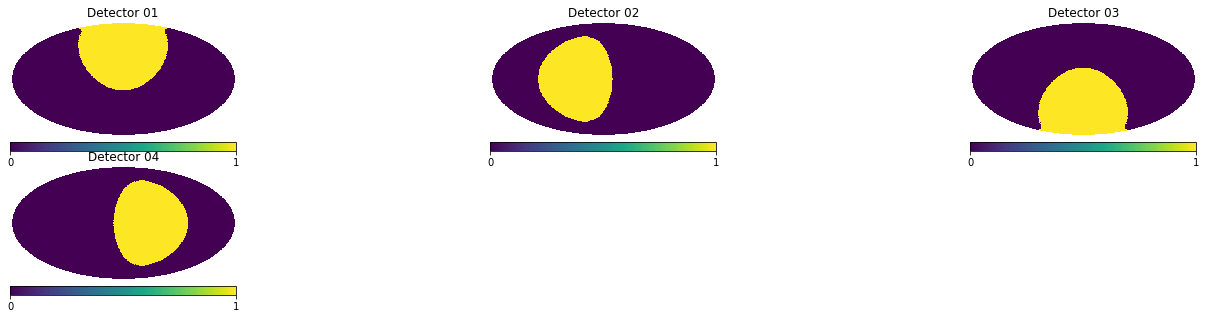

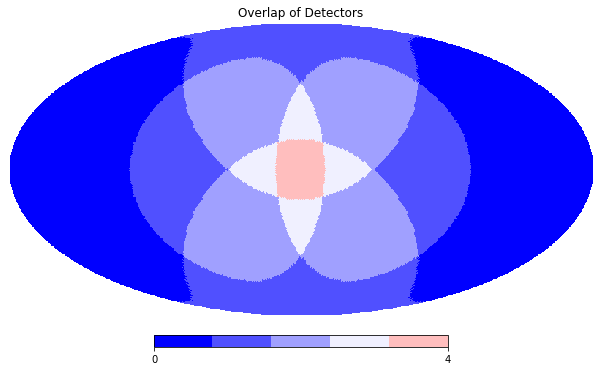

In [2]:
#BurstCube

lat=0.
lon=np.radians(260.)

# pointings = {'01': ('0:0:0','45:0:0'),
#            '02': ('90:0:0','45:0:0'),
#            '03': ('180:0:0','45:0:0'),
#            '04': ('270:0:0','45:0:0')}

# Aeff=61.
# index=0.6

bc, pointings, Aeff, index=load_mission('BurstCube')

NSIDE=64  # resolution of healpix map (64 ~ 50k pixels)
Aeff_fact=1.#2.5
bc,fs,exposure_positions,exposures=plot_exposures(pointings,Aeff_fact,index=index,NSIDE=NSIDE,lon=lon,lat=lat)
fs_det=num_detectors(bc,exposure_positions,pointings,NSIDE=NSIDE,Earth=False)
exposures1=exposures+0.01 #add negligible amount to not crash with divide by 0
npointings=len(pointings)

bcexp=exposures1
print(np.max(bcexp))

In [3]:
w3=np.where(fs_det >=3)[0]
w0=np.where(fs_det >0)[0]
print(float(len(w3))/len(w0))

0.11440736638050401


In [4]:
### make lookup table
npix=len(exposures1[0])
lookup=np.zeros([npointings,npix])

# fill in lookup table
for i in range(npix):
    for j in range(npointings):
        lookup[j,i]=bcexp[j,i]#/max(biaexp[:,i])
# print np.shape(lookup)
# print np.min(lookup),np.max(lookup)

/Users/jracusin/anaconda/envs/py3/lib/python3.7/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


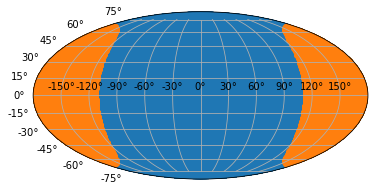

69586


In [5]:
### generate random points on the sky and their relative rates
n=100000
ra,dec=random_sky(n)
burst = np.array([[ detector.exposure(ra[i],dec[i], alt=-23.,index=index) for i in range(n)] for detector in bc.detectors])
burst=burst+0.01#1.0

plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.

pm=plot.scatter(np.radians(ra+msc),np.radians(dec),marker='o')
#we=np.where(np.sum(burst,axis=0)==0.01*npointings)[0]
earthsep=separation(ra,dec,0.,0.)
we=np.where(earthsep>113.)[0]
plot.scatter(np.radians(ra[we]+msc[we]),np.radians(dec[we]),marker='o')
plot.grid(True)
plot.show()

## exclude bursts behind the Earth
#good=np.where(np.sum(burst,axis=0)>0.01*npointings)[0]
good=np.where(earthsep<=113.)[0]
print(len(good))
burst=burst[:,good]
n=len(good)
ra=ra[good]
dec=dec[good]

In [6]:
sep=np.zeros(n)
err1sig=np.zeros(n)
minchisq=np.zeros(n)
snr=np.zeros(n)
#1 sec 50-300 keV peak flux ph/cm2/s
time = 1.0#0.064 # s
minflux=1.0
f=np.logspace(np.log10(minflux),2,50)
p=f**-1.05 # comes from fitting GBM sGRB logN-log peak flux
p=p/np.sum(p)
r=np.random.choice(f,p=p,size=n)
#src=1000.
bg=300.*Aeff/132.*time  # scaling from GBM average background rate
src=r*Aeff*time

## reality, detect count over some time in each detector
## have lookup tables for 3 spectral templates - exposure * integral(Aeff(E) * F(E), 50, 300)
## fit 3 lookup tables with counts, and choose best chisq


sig=np.array([0.68,0.95,0.997])
npar = 2 # number of parameters of interest (ra,dec)
delchisq=stats.chi2.ppf(sig,npar)
print(delchisq)

for k in range(n):  # loop over bursts
    rsrc=np.random.poisson(src[k],1) # randomly vary count rate within Poisson distribution
    s=rsrc*burst[:,k]+bg
#    s=src[k]*burst[:,k]+bg
    s.reshape((npointings,1))
    b=np.repeat(bg,npointings)
    b.reshape(npointings,1)
    snrs=(s-b)/np.sqrt(s)
    snr[k]=snrs[np.argsort(snrs)][-2] # second most on-axis detector significance
#     chisq=np.zeros(npix)
#     for i in range(npix):
#         m=lookup[:,i]
#         f=np.sum(m*(s-b)/s)/np.sum(m**2/s)
#         chisq[i]=np.sum((s-b-f*m)**2/(b+f*m))
    m=lookup#[:,i]
    f=np.sum(m*(s[:,None]-b[:,None])/s[:,None],axis=0)/np.sum(m**2/s[:,None],axis=0)
    chisq=np.sum((s[:,None]-b[:,None]-f*m)**2/(b[:,None]+f*m),axis=0)

    bestfit=np.argmin(chisq)#w[np.argmin(chisq[w])]
    minchisq[k]=chisq[bestfit]
    sep[k]=separation(exposure_positions[0,bestfit],exposure_positions[1,bestfit],ra[k],dec[k])
    w1sig=float(len(np.where((chisq>0) & (chisq<(np.min(chisq)+delchisq[0])))[0]))
#    w1sig=float(len(np.where((chisq>0) & (chisq<(np.min(chisq)+1.0)))[0]))
    err1sig[k]=np.sqrt(w1sig/npix*41253./np.pi)
    if err1sig[k]==0.: err1sig[k]=100.

[ 2.27886857  5.99146455 11.61828598]


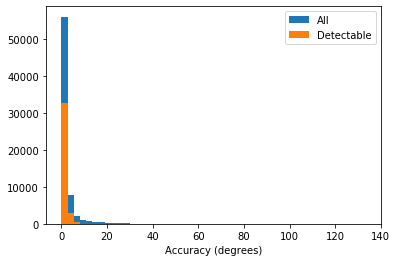

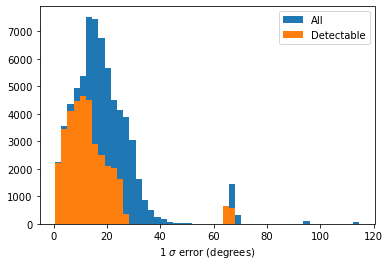

In [7]:
### which bursts are significant >4.5sigma in the 2nd brightest detector
wsig=np.where(snr>=4.5)[0]

h=plot.hist(sep,bins=np.linspace(np.min(sep),np.max(sep),50),label='All')
h=plot.hist(sep[wsig],bins=np.linspace(np.min(sep),np.max(sep),50),label='Detectable')
plot.xlabel('Accuracy (degrees)')
plot.legend()
plot.show()
h=plot.hist(err1sig,bins=np.linspace(np.min(err1sig),np.max(err1sig),50),label='All')
h=plot.hist(err1sig[wsig],bins=np.linspace(np.min(err1sig),np.max(err1sig),50),label='Detectable')
plot.xlabel(r'1 $\sigma$ error (degrees)')
plot.legend()
plot.show()


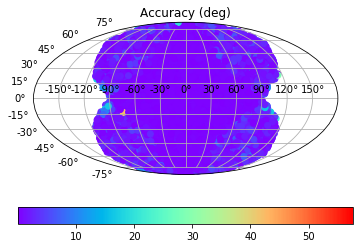

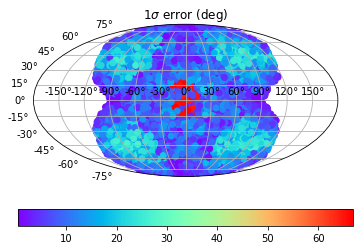

In [8]:
plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.
pm=plot.scatter(np.radians(ra[wsig]+msc[wsig]),np.radians(dec[wsig]),marker='o',c=sep[wsig],cmap=cm.rainbow)
plot.title('Accuracy (deg)')
plot.grid(True)
plot.colorbar(pm,orientation='horizontal')
plot.show()

plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.
pm=plot.scatter(np.radians(ra[wsig]+msc[wsig]),np.radians(dec[wsig]),marker='o',c=err1sig[wsig],cmap=cm.rainbow)
plot.title(r'1$\sigma$ error (deg)')
plot.grid(True)
plot.colorbar(pm,orientation='horizontal')
plot.show()

0.019324216066788524 3.130163078385688
2.946908212386745e-05 6.282764039728675


/Users/jracusin/anaconda/envs/py3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


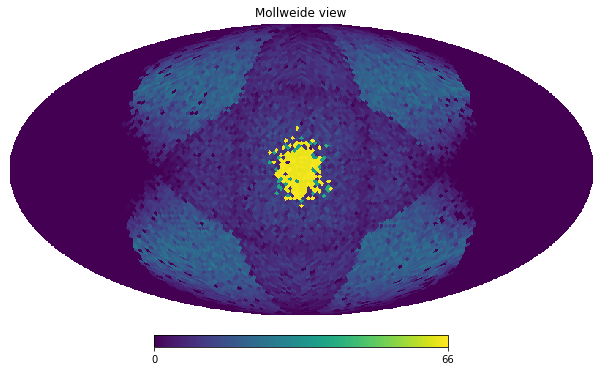

In [9]:
nside=32
npix = hp.nside2npix(nside)

l=ra[wsig]
b=dec[wsig]
err=err1sig[wsig]
# conver to theta, phi
theta = np.radians(90. - b)
phi = np.radians(l)

# convert to HEALPix indices
indices = hp.ang2pix(nside, theta, phi)

idx, counts = np.unique(indices, return_counts=True)

mederr=np.zeros(len(idx))
for i in range(len(idx)):
    w=np.where((indices == idx[i]) & (err < 100) & (err > 0))[0]
    mederr[i]=np.median(err[w])

# fill the fullsky map
hpx_map = np.zeros(npix, dtype=int)
hpx_map[idx] = mederr 
hp.mollview(hpx_map,min=0)

print(np.min(theta),np.max(theta))
print(np.min(phi),np.max(phi))
x = np.linspace(np.min(theta),np.max(theta), num=500)
y = np.linspace(np.min(phi),np.max(phi), num=500)
xx, yy = np.meshgrid(x, y)
zz=hp.ang2pix(nside,theta, phi)
v=hp.pixelfunc.get_interp_val(hpx_map, x,y)
plot.savefig('BC_localization_map.pdf')
#plot.contour(z,x,y)

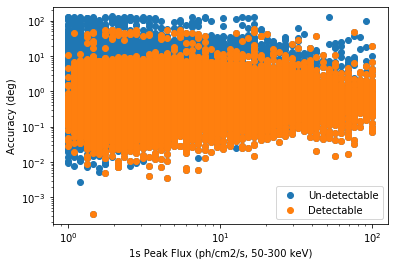

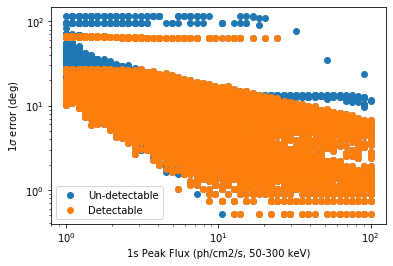

[0.03284231 0.12774674 0.24299448 0.41647922 0.53719677 0.63683568
 0.66926466 0.73397498 0.79606767 0.81840796 0.8356383  0.86972939
 0.86353945 0.87964459 0.9        0.89081633 0.89242054 0.90544041
 0.910162   0.91231029 0.90962672 0.9205298  0.9321267  0.92307692
 0.91373802 0.91638796 0.93277311 0.93493976 0.94680851 0.91411043
 0.93382353 0.91961415 0.96330275 0.94392523 0.91463415 0.91616766
 0.89552239 0.94339623 0.91596639]


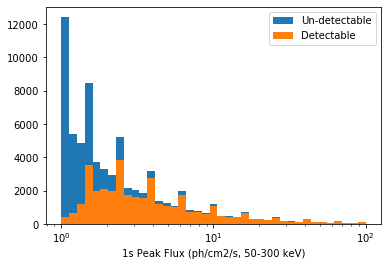

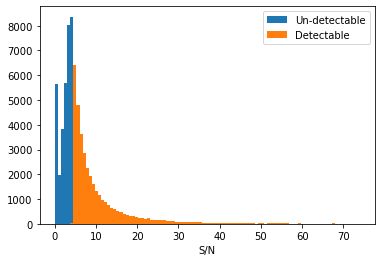

In [10]:
plot.plot(r,sep,marker='o',linestyle='None',label='Un-detectable')
plot.plot(r[wsig],sep[wsig],marker='o',linestyle='None',label='Detectable')
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.ylabel('Accuracy (deg)')
plot.xscale('log')
plot.yscale('log')
plot.legend()
plot.show()

plot.plot(r,err1sig,marker='o',linestyle='None',label='Un-detectable')
plot.plot(r[wsig],err1sig[wsig],marker='o',linestyle='None',label='Detectable')
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.ylabel(r'1$\sigma$ error (deg)')
plot.xscale('log')
plot.yscale('log')
plot.legend()
plot.show()

h1=plot.hist(r,bins=np.logspace(np.log10(np.min(r)),np.log10(np.max(r)),40),label='Un-detectable')
h2=plot.hist(r[wsig],bins=np.logspace(np.log10(np.min(r)),np.log10(np.max(r)),40),label='Detectable')
wh=np.where((h2[0]/h1[0])>=0.9)[0]
sens=h2[1][wh[0]]
print(h2[0]/h1[0])
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.xscale('log')
plot.legend()
plot.show()
n10=int(np.round(len(wsig)*0.1))
w10=np.argsort(r[wsig])
sens2=r[wsig[w10[n10]]]
sens3=h2[1][np.argmax(h2[0])]

plot.hist(snr,bins=np.linspace(np.min(snr),np.max(snr),100),label='Un-detectable')
plot.hist(snr[wsig],bins=np.linspace(np.min(snr),np.max(snr),100),label='Detectable')
plot.legend()
plot.xlabel('S/N')
plot.show()

/Users/jracusin/anaconda/envs/py3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


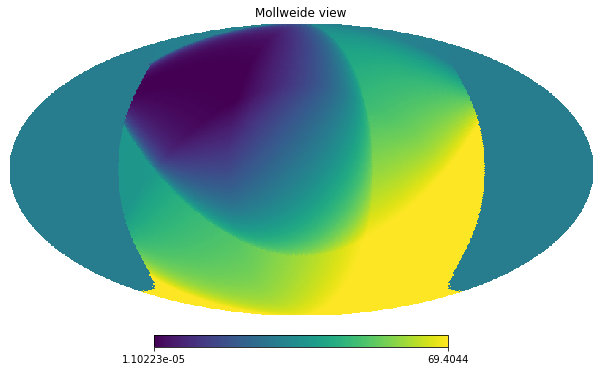

77.94991723108043
65.1831611799396
52.426119467505394
86.57220194775516 49.79935403341214 89.16666666666666 49.70239032663068 1.6790334046877207


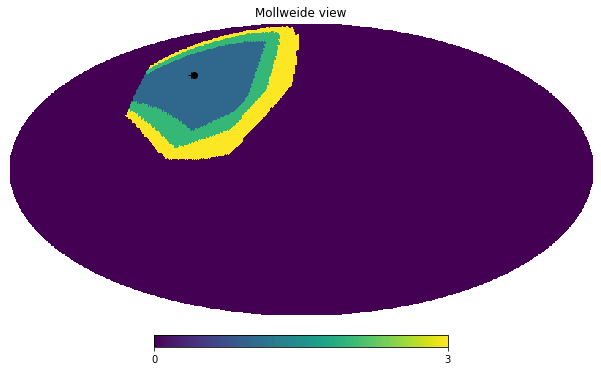

In [11]:
## Let's plot an example chisq map, and localization contour (using last burst in loop)

hp.mollview(chisq)
plot.show()

chisq_map = np.zeros(hp.nside2npix(NSIDE))
#chisq_map=np.vstack(hp.pix2ang(NSIDE, chisq_hp, lonlat=True))
w=np.where(chisq <(np.min(chisq)+delchisq[2]))[0]
print(np.sqrt(float(len(w))/float(npix)*41253./np.pi))
chisq_map[w]=3
w=np.where(chisq <(np.min(chisq)+delchisq[1]))[0]
print(np.sqrt(float(len(w))/float(npix)*41253./np.pi))
chisq_map[w]=2
w=np.where(chisq <(np.min(chisq)+delchisq[0]))[0]
print(np.sqrt(float(len(w))/float(npix)*41253./np.pi))
chisq_map[w]=1
hp.mollview(chisq_map)
hp.projplot(ra[-1],dec[-1],marker='o',color='black',lonlat=True)
hp.projplot(exposure_positions[0,bestfit],exposure_positions[1,bestfit],marker='+',color='black',lonlat=True)
print(ra[-1],dec[-1],exposure_positions[0,bestfit],exposure_positions[1,bestfit],sep[-1])
plot.show()

In [12]:
## What fraction of bursts have their accuracy better than their 1 sigma error?

print(len(np.where(sep<err1sig)[0]))
print(n)
print(float(len(np.where(sep<err1sig)[0]))/n)

67919
69586
0.9760440318454862


In [13]:
## check requirement that 80% with peak flux > 1 ph/cm2/s (50-300 keV) have 1sigerr<10 deg
n1=float(len(np.where(r[wsig]>=1.)[0]))
n2=float(len(np.where((r[wsig]>=1.) & (err1sig[wsig]<=10.))[0]))
print(n2/n1)

0.4025765341460036


In [14]:
print('Min Flux= ',np.min(r[wsig]))
print('90% Complete sensitivity = ',sens,sens2,sens3)
print('Median error radius = ',np.median(err1sig[wsig]))
wb=np.where((r[wsig]>=1.))[0]# & (err1sig[wsig]<=10.))[0]
print('Median error radius for bright events = ',np.median(err1sig[wsig[wb]]))
# n8=int(np.round(0.8*float(len(wb))))
# sortsig=np.sort(err1sig[wsig[wb]])
# print '80th percentile localization= ',sortsig[n8]

Min Flux=  1.0
90% Complete sensitivity =  5.223345074266842 1.4563484775012439 2.2854638641349903
Median error radius =  11.741054010014112
Median error radius for bright events =  11.741054010014112
